# How active is myDRE being used?

Activity is measured via this script by:
- Succeeded VM starts

## How to
### in portal.azure.com
- Log into portal.azure.com
- Select a Workspace Subscription
- Select Activity log
- Edit Columns, minimum needed
    - Operation name
    - Time
    - Event initiated by
    - Resource group
    - Resource
- Adjust the Subscription scope (it is possible to select multiple subscriptions)
- Adjust the Timespan (max a month, combine multiple months by saving if need be)
- Filter Operation: Start Virtual Machine (Microsoft.Compute/virtualMachine/start action)
- Download as CSV

### in Jupyter notebook / Python
- Copy the CSV in the same dir as Jupyter notebook / Python
- Update Sub_Dict.csv if needed
     - The Sub_Dict.csv does contain only part of the Subscription ID to provide protection against misuse
- Change the SOURCE_FILE in cell 2
- Run the script
- Some output CSVs are generated for closer inspection/use in Excel

In [1]:
import polars as pl
import pyarrow
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# QueryREsult (2).csv = All VM starts that Succeeded
SOURCE_FILE = 'QueryResult (5).csv'
raw = pl.read_csv(SOURCE_FILE)
succeededVMstarted= raw.filter(pl.col('Status') == 'Succeeded')

In [3]:
#print(succeededVMstarted.columns)

In [4]:
# Get subscription dictionary to replace UUIDs with readable IDs
SOURCE_FILE='Sub_Dict.csv'
df=pd.read_csv(SOURCE_FILE).set_index('id')
subscription_dictionary = df.to_dict()

In [5]:
# limit to only columns needed
reduced_data=succeededVMstarted.select(['Time', 'Resource group', 'Resource', 'Event initiated by', 'Subscription'])

# replace Subscription ID with meaningful
reduced_data=reduced_data.with_columns(reduced_data['Subscription'].apply(lambda x: subscription_dictionary['name'][x[:15]][18:]))

# Create dataset with at most one successful login per day
reduced_data=reduced_data.with_columns(reduced_data['Time'].apply(lambda x: x[:-14]))
reduced_data=reduced_data.with_columns((pl.col('Resource group') + '_server' + pl.col('Resource').apply(lambda x: x[-2:].replace('r', '0'))).alias('VM'))
# reduced_data = reduced_data[['Time', 'Resource group', 'VM', 'Event initiated by']].unique()

# limit to only columns of interest
reduced_data=reduced_data.with_columns(pl.lit(1).alias('Counter'))
reduced_data=reduced_data.select(['Time', 'Resource group', 'Event initiated by', 'VM', 'Subscription','Counter'])
print(reduced_data)
date=f'{min(reduced_data["Time"])} - {max(reduced_data["Time"])}'
reduced_data.write_csv('reduced_data '+ date + '.csv')

shape: (3611, 6)
┌────────────┬───────────────────┬──────────────────────────┬────────────────────────────┬──────────────┬─────────┐
│ Time       ┆ Resource group    ┆ Event initiated by       ┆ VM                         ┆ Subscription ┆ Counter │
│ ---        ┆ ---               ┆ ---                      ┆ ---                        ┆ ---          ┆ ---     │
│ str        ┆ str               ┆ str                      ┆ str                        ┆ str          ┆ i32     │
╞════════════╪═══════════════════╪══════════════════════════╪════════════════════════════╪══════════════╪═════════╡
│ 2023-01-31 ┆ dws-743-ILIVE     ┆ veroveloso.01@mydre.org  ┆ dws-743-ILIVE_server02     ┆ EM-0002      ┆ 1       │
│ 2023-01-31 ┆ dws-1584-lrgp2022 ┆ Ziyi.Wang@mydre.org      ┆ dws-1584-lrgp2022_server01 ┆ UM-0001      ┆ 1       │
│ 2023-01-31 ┆ dws-969-NEUREEG   ┆ k.vanderkuil@mydre.org   ┆ dws-969-NEUREEG_server01   ┆ EM-0001      ┆ 1       │
│ 2023-01-31 ┆ dws-1415-ls7      ┆ Femke.teHoonte@mydre

## VMs Start Succeeded in Subscription

- Number of VM succeeded starts per day per subsription

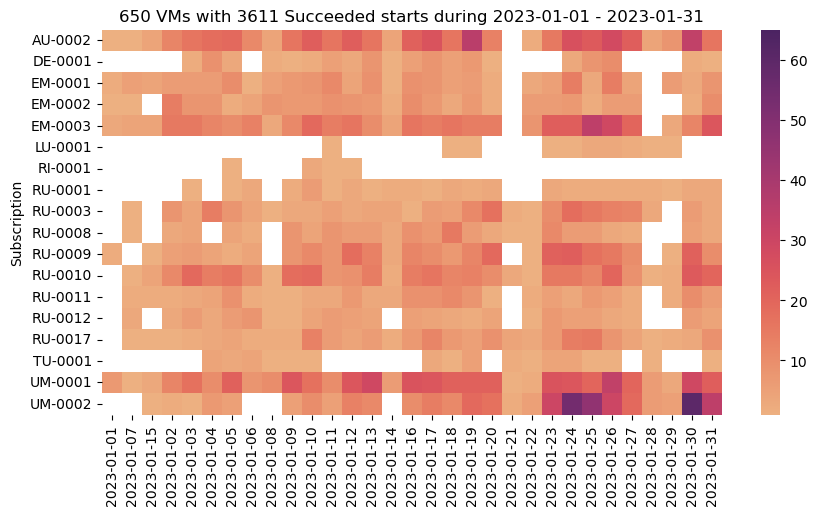

In [22]:
item = 'Subscription'
table=reduced_data.pivot(columns='Time', index=item, values='Counter', aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
# print(table)
result = table.to_pandas()
result = result.set_index(item)
result.sort_index(level=0, ascending=True, inplace=True)
vms = len(set(reduced_data['VM']))
vm_starts = sum(reduced_data['Counter'])
title=f'{vms} VMs with {vm_starts} Succeeded starts during {min(result.columns)} - {max(result.columns)}'
fig, ax = plt.subplots(figsize=(10,5))
figure = sns.heatmap(result, cmap='flare', mask=result<1, vmin=1, vmax=(max(result.max())//5+1)*5)
figure.set(title=title)
figure.invert_xaxis()

In [7]:
print((max(result.max())//5+1)*5)

65


In [8]:
item1 = 'Subscription'
item2 = 'Resource group'
sorton = 'VMs started'
sorton = ['Subscription', 'VMs started']
# sorton = 'Subscription'
table2=(reduced_data
       .groupby([item1, item2])
       .agg([
           pl.col('Counter').sum().alias('VMs started')
       ])
      ).sort(sorton, True)
print('='*60)
print(f"{title:^60}")
print('-'*60)
print(table2)
date=f'{min(result.columns)} - {max(result.columns)}'
table2.write_csv(item1+'-'+item2 + '-' + date + '.csv')

        Succeeded VM starts: 2023-01-01 - 2023-01-31        
------------------------------------------------------------
shape: (421, 3)
┌──────────────┬───────────────────┬─────────────┐
│ Subscription ┆ Resource group    ┆ VMs started │
│ ---          ┆ ---               ┆ ---         │
│ str          ┆ str               ┆ i32         │
╞══════════════╪═══════════════════╪═════════════╡
│ UM-0002      ┆ dws-1705-fpbb2    ┆ 83          │
│ UM-0002      ┆ dws-1707-fpbb4    ┆ 61          │
│ UM-0002      ┆ dws-483-CNCPTION  ┆ 45          │
│ UM-0002      ┆ dws-1646-J202204  ┆ 25          │
│ ...          ┆ ...               ┆ ...         │
│ AU-0002      ┆ dws-869-aumcslpd  ┆ 1           │
│ AU-0002      ┆ dws-759-ctrl      ┆ 1           │
│ AU-0002      ┆ dws-1361-aumcrsc2 ┆ 1           │
│ AU-0002      ┆ dws-364-AUMCICT   ┆ 1           │
└──────────────┴───────────────────┴─────────────┘


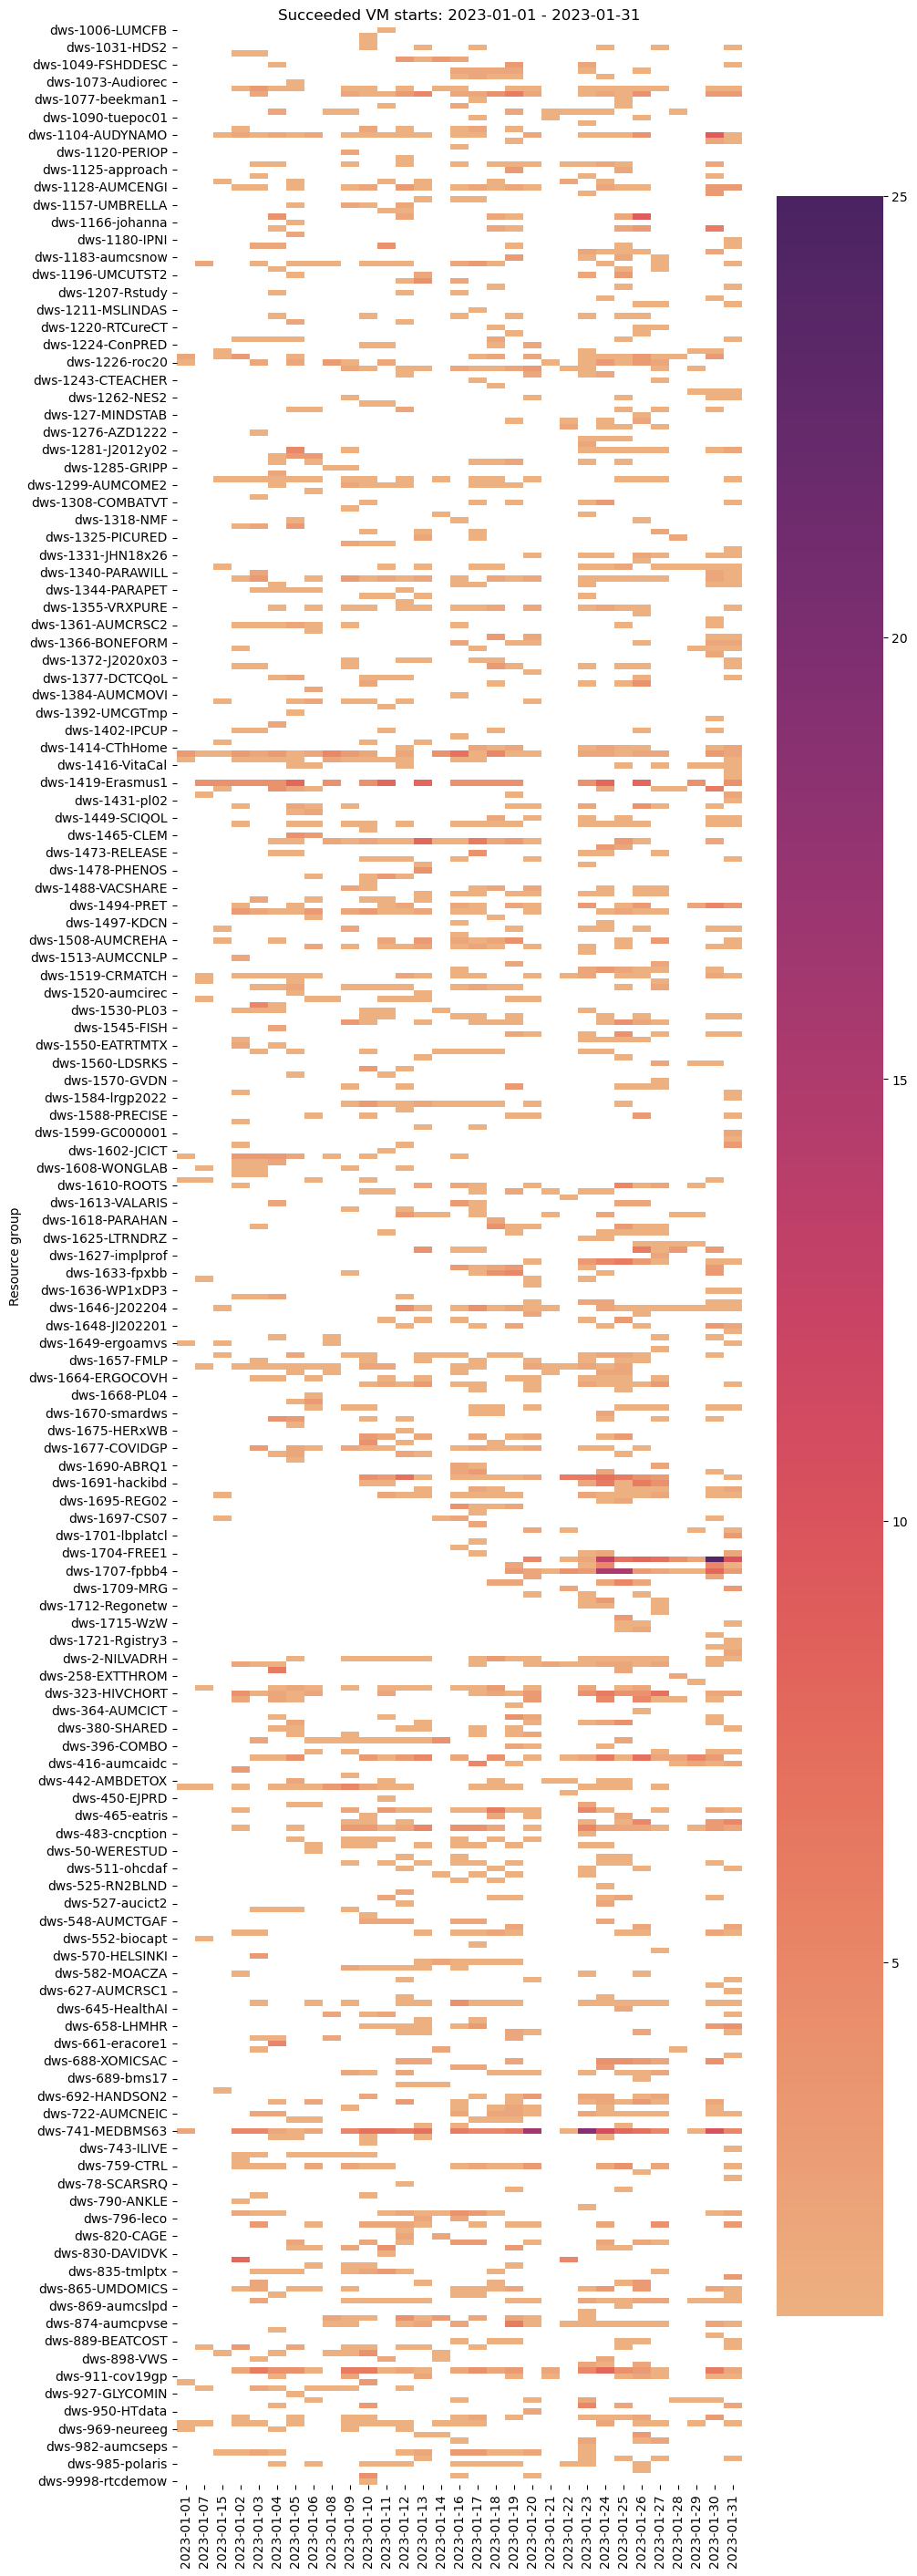

In [9]:
item = 'Resource group'
table=reduced_data.pivot(columns='Time', index=item, values='Counter', aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
# print(table)
result = table.to_pandas()
result = result.set_index(item)
result.sort_index(level=0, ascending=True, inplace=True)
title=f'Succeeded VM starts: {min(result.columns)} - {max(result.columns)}'
fig, ax = plt.subplots(figsize=(10,35))
figure = sns.heatmap(result, cmap='flare', mask=result<1, vmax=(max(result.max())//5+1)*5)
figure.set(title=title)
figure.invert_xaxis()

## Active WSs in Subscription

- Number of Active WSs per day per subsription
   - Active WS = 1 or more VM start succeeeded of that WS

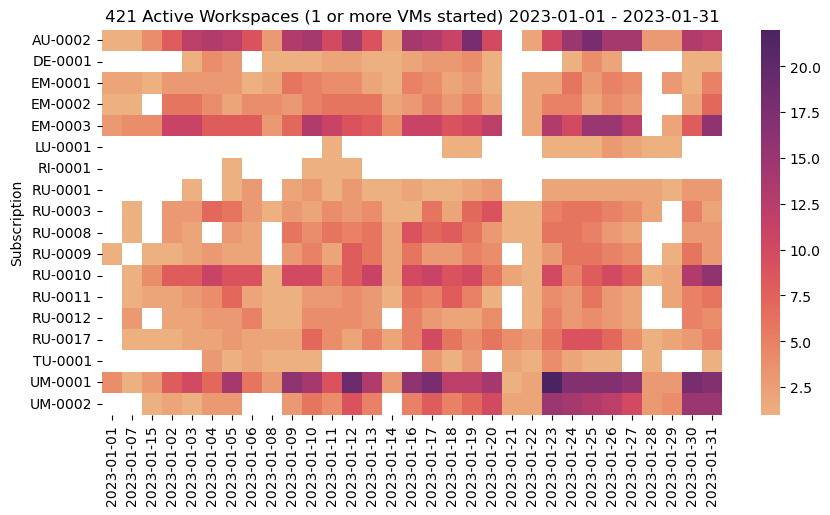

In [26]:
reduced_data2 = reduced_data[['Time', 'Subscription', 'Resource group']].unique()
reduced_data2=reduced_data2.with_columns(pl.lit(1).alias('Counter'))
item = 'Subscription'
table=reduced_data2.pivot(columns='Time', index=item, values='Counter', aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
# print(table)
active_wss = len(set(reduced_data2['Resource group']))
result = table.to_pandas()
result = result.set_index(item)
result.sort_index(level=0, ascending=True, inplace=True)
title=f'{active_wss} Active Workspaces (1 or more VMs started) {min(result.columns)} - {max(result.columns)}'
fig, ax = plt.subplots(figsize=(10,5))
figure = sns.heatmap(result, cmap='flare', mask=result<1) #, vmin=1, vmax=(max(result.max())//5+1)*5)
figure.set(title=title)
figure.invert_xaxis()

## # of Active Users

- Number of Users per day per subsription
   - Active user = started 1 or more VM start succeeeded


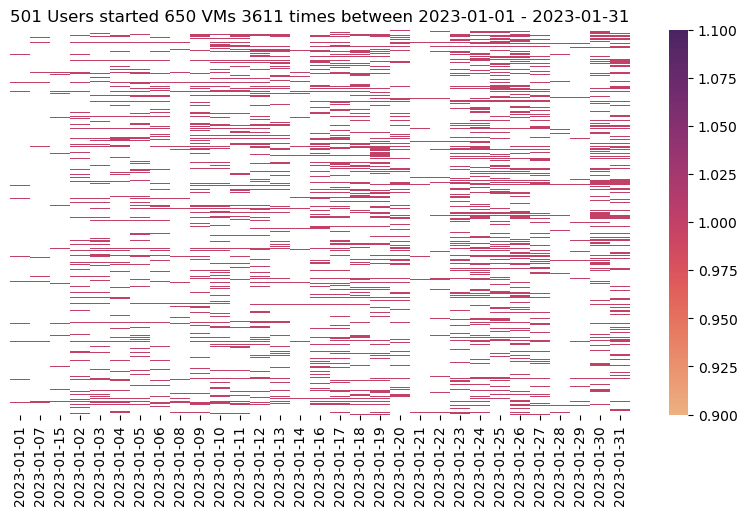

In [24]:
reduced_data3 = reduced_data[['Time', 'Event initiated by']].unique()
reduced_data3=reduced_data3.with_columns(pl.lit(1).alias('Counter'))
item = 'Event initiated by'
table=reduced_data3.pivot(columns='Time', index=item, values='Counter', aggregate_fn='sum').with_column(pl.col(pl.Int32).fill_null(pl.lit(0)))
# print(table)
active_users = len(set(reduced_data3['Event initiated by']))
result = table.to_pandas()
result = result.set_index(item)
result.sort_index(level=0, ascending=True, inplace=True)
title=f'{active_users} Users started {vms} VMs {vm_starts} times between {min(result.columns)} - {max(result.columns)}'
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(result, cmap='flare', mask=result<1) #, vmin=1, vmax=(max(result.max())//5+1)*5)
ax.set(title=title)
ax.set(ylabel=None)
ax.tick_params(left=False)
ax.set_yticklabels([])
ax.invert_xaxis()

In [12]:
len(set(reduced_data3['Event initiated by']))

501